In [249]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.dates import DateFormatter
from matplotlib.dates import AutoDateLocator
from matplotlib.dates import ConciseDateFormatter
import pandas as pd
from scipy import integrate 
from scipy import optimize
from scipy import stats
from scipy.interpolate import interp1d
from datetime import datetime
from metpy.units import units
from siphon.simplewebservice.wyoming import WyomingUpperAir

# Read data

In [250]:
%run profile_read_py.py

In [251]:
%run profile_read_py.py
arquivo = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/RMlicelPython/30/RM1183010.264' #30 agosto 2011
arquivo = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/RMlicelPython/30/RM1183008.054'
#arquivo = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/RMlicelPython/30/RM1183000.223'

#arquivo = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/RMlicelPython/30/' + f'{file_test}'

read = profile_read(arquivo, dbin=10)
phy  = read[1]

df = pd.DataFrame(phy)

# Aqui é um jeito provisório de fazer o header

lista = []
for i in range(len(read[0]['ch']['active'])):
    wlen = str(read[0]['ch']['wlen'][i])
    pol = str(read[0]['ch']['pol'][i])
    photon = read[0]['ch']['photons'][i]
    an = 'analog' if photon == 0 else 'photon'
    tr = read[0]['ch']['tr'][i]
    lista.append(wlen + ' ' + pol + ' ' + an + ' ' + tr[-1])

###############################################


df.columns = lista
alt = 7.5*(np.array(df.index) + 1)

df['alt'] = alt
s355 = df['355 o analog 0']

df.set_index('alt', inplace=True)

In [252]:
read[0]

{'file': 'RM1183008.054',
 'site': 'Embrapa_',
 'datei': '30/08/2011',
 'houri': '08:04:48',
 'datef': '30/08/2011',
 'hourf': '08:05:48',
 'jdi': 734745.3366666667,
 'jdf': 734745.3373611111,
 'alt': 100,
 'lon': -60.0,
 'lat': -2.9,
 'zen': -90.0,
 'T0': 30.0,
 'P0': 1013.0,
 'nshoots': 600,
 'nhz': 10,
 'nshoots2': 600,
 'nhz2': 10,
 'nch': 5,
 'ch': {'active': array([1, 1, 1, 1, 1]),
  'photons': array([0, 1, 0, 1, 1]),
  'elastic': array([1, 1, 2, 2, 2]),
  'ndata': array([4000, 4000, 4000, 4000, 4000]),
  'pmtv': array([950, 950, 990, 990, 990]),
  'binw': array([7.5, 7.5, 7.5, 7.5, 7.5]),
  'wlen': array([355, 355, 387, 387, 408]),
  'pol': array(['o', 'o', 'o', 'o', 'o'], dtype='<U6'),
  'bits': array([12,  0, 12,  0,  0]),
  'nshoots': array([600, 600, 600, 600, 600]),
  'discr': array([0.5   , 3.1746, 0.02  , 3.1746, 3.1746]),
  'tr': array(['BT0', 'BC0', 'BT1', 'BC1', 'BC2'], dtype='<U6')}}

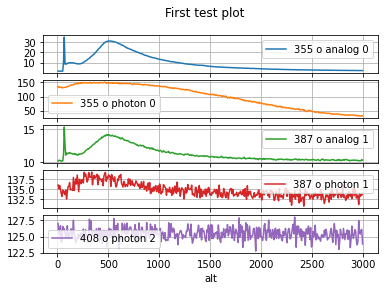

In [253]:
plot = df[:3000].plot(grid=True, subplots=True, title='First test plot')

# Reading multiple data (mean signal)

The idea here is to iterate over the data files in a month directory.

In [255]:
import os

# Seca
Ago30_2011 = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/RMlicelPython/30'
Set2_2011  = '/Users/costaleirbag/Downloads/9/02'
Set1_2011  = '/Users/costaleirbag/Downloads/9/01'
Ago19_2014 = '/Users/costaleirbag/Downloads/8d/19'
Ago18_2014 = '/Users/costaleirbag/Downloads/8d/18'

# Chuva
Jan9_2012  = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/RMlicelPython/Jan2012/09'
Jan31_2012 = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/RMlicelPython/Jan2012/31'
Mar25_2012 = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/RMlicelPython/Data/Chuva/25_Mar_2012/25'
Jan30_2012 = '/Users/costaleirbag/Downloads/1/30'
#Abr22_2012 = '/Users/costaleirbag/Downloads/4/22'
Jan30_2014 = '/Users/costaleirbag/Downloads/30'
Jan31_2014 = '/Users/costaleirbag/floresta.if.usp.br/ftp/old/lidar/data/2014/1/31'
Abr5_2014  = '/Users/costaleirbag/Downloads/05'
Mar29_2014 = '/Users/costaleirbag/Downloads/29'

dark_current = '/Users/costaleirbag/Downloads/2014_06_27_telescope/Dark_Current'

directory = Ago19_2014

# Primeiro testo um arquivo pra saber o tamanho do array gerado, e ai gerar o dataframe
# ja certo.

files = os.listdir(directory)
files.sort()

file_test = files[0]
path = os.path.join(directory, file_test)
read = profile_read(path, dbin=10)
array_size = len(read[1][:, 0])

In [256]:
file_test

'RM1481900.001'

In [257]:
n_files = len(files)
n_files

1834

In [258]:
#n_files = 100
data    = np.zeros((array_size, n_files))
date    = []

cont    = 0
errors  = []

for filename in files[:n_files]:
    print(f'Arquivo: {cont+1}', end='\r')
    path = os.path.join(directory, filename)
    head, phy, raw = profile_read(path, dbin=10)
    date_str = head['datei'] + ' ' + head['houri']
    date.append(datetime.strptime(date_str, "%d/%m/%Y %H:%M:%S"))
    data[:, cont] = phy[:, 0]
    phy = read[1]
    cont += 1
    #print(data)

#date = np.array(date)

errors_str = ', '.join(errors)
print(f'\n  All files with overflow: {errors_str}.')

Arquivo: 1834
  All files with overflow: .


In [259]:
data.shape

(16380, 1834)

In [260]:
alt = np.arange(1, data.shape[0] + 1, 1)*7.5

In [261]:
alt.shape

(16380,)

In [262]:
bg_vec = np.mean(data[-500:], axis=0)
bg_vec.shape

(1834,)

In [263]:
data_nobg = data - bg_vec

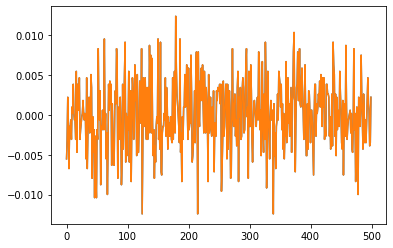

In [264]:
plt.plot(data_nobg[-500:, 0])
plt.plot(data[-500:, 0] - bg_vec[0])

In [265]:
data_nobg.shape

(16380, 1834)

In [266]:
pd.DataFrame(data_nobg.T[0])

,0
0,0.016865
1,0.013610
2,0.013203
3,0.009541
4,0.010355
...,...
16375,0.001403
16376,0.000589
16377,-0.003887
16378,-0.003480


In [267]:
(data_nobg.T * alt * alt).T

array([[ 9.48669434e-01,  1.18336487e+00,  1.88049316e+00, ...,
        -1.93313599e-01, -1.69235229e-01,  2.10845947e-01],
       [ 3.06225586e+00,  4.82501221e+00,  7.97973633e+00, ...,
         1.14935303e+00, -1.40936279e+00, -1.90319824e+00],
       [ 6.68408203e+00,  1.12682648e+01,  1.73364258e+01, ...,
        -2.35780334e+00, -2.75907898e+00, -7.80303955e-01],
       ...,
       [-5.86445119e+07, -2.63875745e+07, -5.15718069e+06, ...,
         3.40128346e+06, -5.76744707e+07,  8.11150849e+07],
       [-5.25114229e+07,  1.65909570e+07, -6.04200656e+07, ...,
         3.40169882e+06, -8.55950930e+06, -1.33783779e+08],
       [ 3.34561700e+07, -7.55220225e+07, -2.35814414e+07, ...,
        -8.87988653e+06, -3.31245560e+07, -7.85311127e+07]])

In [268]:
data_pr2 = pd.DataFrame((data_nobg.T * alt * alt).T, columns=date)
data_pr2['Altitude'] = alt
data_pr2.set_index('Altitude', inplace=True)


# Tirando medias de 5 em 5 min
data_pr2.columns = pd.to_datetime(data_pr2.columns)
data_pr2 = data_pr2.resample('5T', axis=1).mean()
data_pr2[data_pr2 < 0] = np.nan   # Fazendo valores negativos virarem nan

data_pr2

,2014-08-18 23:55:00,2014-08-19 00:00:00,2014-08-19 00:05:00,2014-08-19 00:10:00,2014-08-19 00:15:00,2014-08-19 00:20:00,2014-08-19 00:25:00,2014-08-19 00:30:00,2014-08-19 00:35:00,2014-08-19 00:40:00,...,2014-08-19 23:10:00,2014-08-19 23:15:00,2014-08-19 23:20:00,2014-08-19 23:25:00,2014-08-19 23:30:00,2014-08-19 23:35:00,2014-08-19 23:40:00,2014-08-19 23:45:00,2014-08-19 23:50:00,2014-08-19 23:55:00
Altitude,,,,,,,,,,,,,,,,,,,,,
7.5,9.486694e-01,1.299257e+00,NaN,2.671555e-01,3.185623e-01,0.176814,1.082089e+00,NaN,2.634384e-01,8.123474e-02,...,1.157379e-01,7.931305e-01,NaN,2.338120e-01,1.089935e-02,0.220894,5.728709e-01,NaN,3.753387e-01,NaN
15.0,3.062256e+00,5.041388e+00,NaN,3.636658e-01,1.667926e+00,0.330872,4.273425e+00,1.001587e-01,1.905194e+00,6.087524e-01,...,8.495076e-01,2.888708e+00,NaN,5.781921e-01,5.288269e-01,0.819489,2.657694e+00,NaN,6.865356e-01,4.829508e-01
22.5,6.684082e+00,1.031315e+01,NaN,2.672191e+00,3.588039e+00,0.218033,9.409213e+00,NaN,3.112523e+00,2.337863e+00,...,1.270523e+00,7.220572e+00,NaN,8.683456e-01,6.748764e-01,2.379433,4.766739e+00,NaN,1.070920e+00,1.132416e+00
30.0,8.586914e+00,1.939651e+01,NaN,3.395581e+00,7.330884e+00,1.567627,1.599507e+01,NaN,2.713550e+00,3.863232e+00,...,4.455973e+00,1.118862e+01,NaN,8.113037e-01,NaN,3.021606,9.857666e+00,NaN,3.258838e+00,1.402832e+00
37.5,1.456146e+01,3.110813e+01,NaN,5.305595e+00,1.019566e+01,2.512995,2.779610e+01,NaN,9.103661e+00,6.951828e+00,...,2.702713e+00,1.816887e+01,NaN,6.074181e+00,1.016350e+00,5.694008,1.724637e+01,NaN,6.865768e+00,4.417165e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122820.0,2.116383e+07,5.311826e+06,6.883155e+06,NaN,NaN,NaN,2.748106e+07,NaN,NaN,2.485400e+07,...,9.213822e+06,4.697044e+07,2.391198e+07,NaN,1.704032e+07,NaN,NaN,NaN,2.945504e+07,3.052633e+06
122827.5,8.888912e+06,NaN,2.586870e+06,NaN,1.423085e+07,NaN,2.687054e+07,NaN,1.970416e+07,NaN,...,NaN,1.812405e+07,NaN,1.851079e+07,1.695523e+06,NaN,NaN,5.747099e+06,7.359135e+06,NaN
122835.0,NaN,NaN,3.881024e+07,8.424623e+06,NaN,NaN,NaN,NaN,2.277632e+07,3.020634e+05,...,5.123072e+06,9.356599e+05,6.745578e+06,3.017810e+07,2.195608e+07,NaN,4.953895e+06,2.293840e+07,3.375989e+07,1.328588e+07


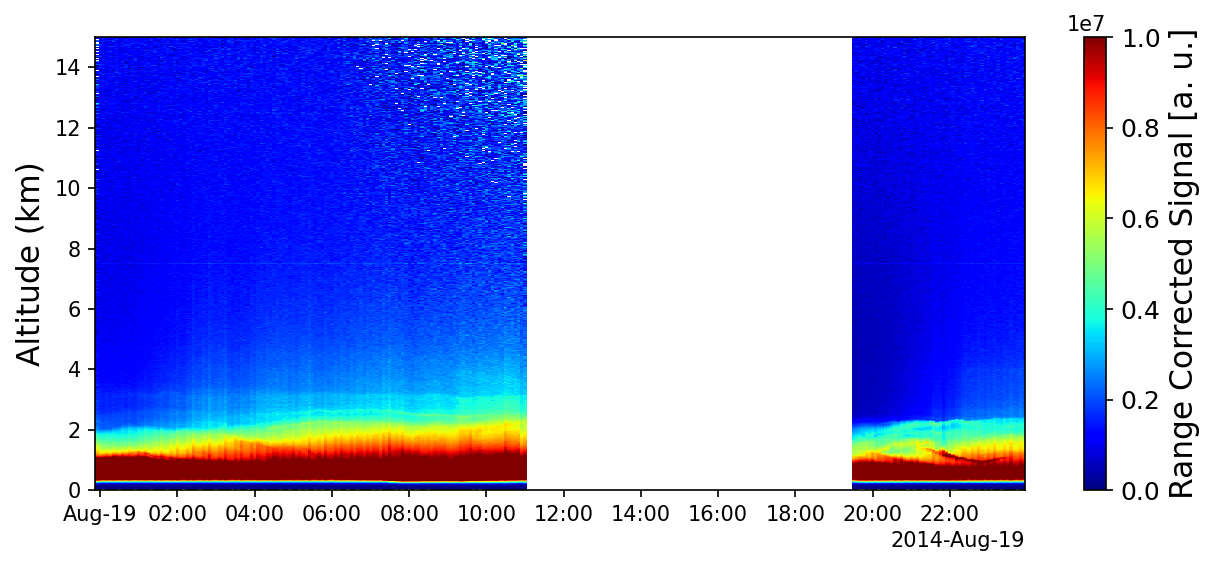

In [269]:
norm = colors.LogNorm()

fig, ax = plt.subplots(figsize = (10,4), dpi=150)

psm = ax.pcolormesh(data_pr2.columns, alt*1e-3, (data_pr2), vmin = 0, vmax=1e7, cmap='jet')

cbar = fig.colorbar(psm, ax=ax, label = "Range Corrected Signal [a. u.]")

#ax.set_xlabel("Date", fontsize=15)

ax.set_ylabel("Altitude (km)", fontsize=15)

ax.set_ylim(0, 15)

cbar.ax.tick_params(labelsize=12)

ax.figure.axes[-1].yaxis.label.set_size(15)

# date_form = DateFormatter("%d/%m/%Y \n%H:%M:%S")
# ax.xaxis.set_major_formatter(date_form)

locator   = AutoDateLocator(minticks=2, maxticks=16)
formatter = ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.savefig('ExamplePlot_5Abr2014.png', dpi=300)
plt.show()

In [270]:
maximum_value = data_pr2.max().max()
maximum_value

476182696.90088236

# Tirando as médias

### Lidando com dark_current

In [271]:
################

initial = 0
final = initial + 22                  # Tomando medias de 30 minutos

data = np.zeros((array_size, final - initial))
cont = 0


files = os.listdir(dark_current)
files.sort()                          # A lista tem que estar ordenada para as medias.

for filename in files[initial:final]:
    path = os.path.join(dark_current, filename)
    read = profile_read(path)
    data[:, cont] = read[1][:, 0]
    phy = read[1]
    cont += 1
    #print(data)

In [272]:
df = pd.DataFrame(data)
dc = np.mean(df, axis=1)

In [292]:
################

initial = 118
final = initial + 60                  # Tomando medias de 30 minutos

data = np.zeros((array_size, final - initial))
cont = 0

files = os.listdir(directory)
files.sort()                          # A lista tem que estar ordenada para as medias.

for filename in files[initial:final]:
    path = os.path.join(directory, filename)
    read = profile_read(path)
    data[:, cont] = read[1][:, 0]
    phy = read[1]
    cont += 1
    #print(data)

In [293]:
read[0]

{'file': 'RM1481901.295',
 'site': 'embrapa',
 'datei': '19/08/2014',
 'houri': '01:29:29',
 'datef': '19/08/2014',
 'hourf': '01:29:59',
 'jdi': 735830.0621412037,
 'jdf': 735830.0624884259,
 'alt': 100,
 'lon': -60.0,
 'lat': -3.0,
 'zen': -5.0,
 'T0': 30.0,
 'P0': 1013.0,
 'nshoots': 300,
 'nhz': 10,
 'nshoots2': 0,
 'nhz2': 10,
 'nch': 5,
 'ch': {'active': array([1, 1, 1, 1, 1]),
  'photons': array([0, 1, 0, 1, 1]),
  'elastic': array([1, 1, 1, 1, 1]),
  'ndata': array([16380, 16380, 16380, 16380, 16380]),
  'pmtv': array([920, 920, 990, 990, 990]),
  'binw': array([7.5, 7.5, 7.5, 7.5, 7.5]),
  'wlen': array([355, 355, 387, 387, 408]),
  'pol': array(['o', 'o', 'o', 'o', 'o'], dtype='<U6'),
  'bits': array([12,  0, 12,  0,  0]),
  'nshoots': array([300, 300, 300, 300, 300]),
  'discr': array([0.5   , 3.1746, 0.1   , 3.1746, 0.    ]),
  'tr': array(['BT0', 'BC0', 'BT1', 'BC1', 'BC2'], dtype='<U6')}}

## Para conferir se os dados estão sendo lidos

In [294]:
#os.listdir(directory)

bg_vec = np.mean(data[-500:], axis=0)
bg_vec.shape

data_nobg = data - bg_vec

In [295]:
df = pd.DataFrame(data)
#df.columns = lista
df

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,1.481527,1.483968,1.470947,1.479085,1.468506,1.464844,1.475016,1.489665,1.485596,1.497396,...,1.481120,1.466064,1.464437,1.460775,1.464844,1.473796,1.489665,1.489665,1.494954,1.501058
1,1.479492,1.483561,1.472982,1.466064,1.468913,1.474202,1.477865,1.488444,1.490885,1.510824,...,1.473796,1.472982,1.463623,1.456706,1.459147,1.464030,1.483561,1.488851,1.494141,1.498210
2,1.488037,1.489258,1.477051,1.475016,1.460368,1.462809,1.471761,1.481120,1.499430,1.501465,...,1.477865,1.472168,1.460775,1.462809,1.460368,1.463216,1.481120,1.490072,1.487223,1.495361
3,1.483561,1.475830,1.479085,1.465251,1.468099,1.461589,1.476237,1.492920,1.488037,1.510417,...,1.472575,1.468099,1.465251,1.459554,1.468099,1.467692,1.495361,1.493327,1.498617,1.496582
4,1.478678,1.490479,1.481934,1.469320,1.472575,1.466471,1.473389,1.488037,1.493327,1.509196,...,1.472168,1.472168,1.464844,1.456706,1.455485,1.466471,1.493327,1.484782,1.498617,1.494548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16375,1.484375,1.486816,1.477865,1.475423,1.475423,1.470947,1.472168,1.470540,1.477458,1.486816,...,1.473796,1.476644,1.455892,1.467285,1.454264,1.466878,1.463623,1.468099,1.475830,1.485596
16376,1.480713,1.487630,1.474609,1.479492,1.468099,1.468506,1.466471,1.476237,1.482340,1.479492,...,1.477865,1.475016,1.473389,1.464437,1.458740,1.459554,1.458333,1.466064,1.474609,1.485596
16377,1.483154,1.488444,1.473796,1.473796,1.468099,1.467285,1.475423,1.471761,1.471761,1.480306,...,1.477865,1.473389,1.466878,1.466471,1.470133,1.470133,1.464030,1.459961,1.474202,1.481934
16378,1.487630,1.479085,1.475423,1.476644,1.470947,1.464437,1.476237,1.470133,1.477865,1.484375,...,1.474609,1.479085,1.466878,1.474609,1.470133,1.464437,1.459147,1.468506,1.468913,1.490072


In [296]:
if len(dc) == len(s355):
    print('entrou')
    s355 = np.mean(df, axis=1) - dc
else:
    s355 = np.mean(df, axis=1)
alt = 7.5*(np.array(s355.index) + 1)
s355.shape

(16380,)

In [297]:
s355 = np.mean(df, axis=1)

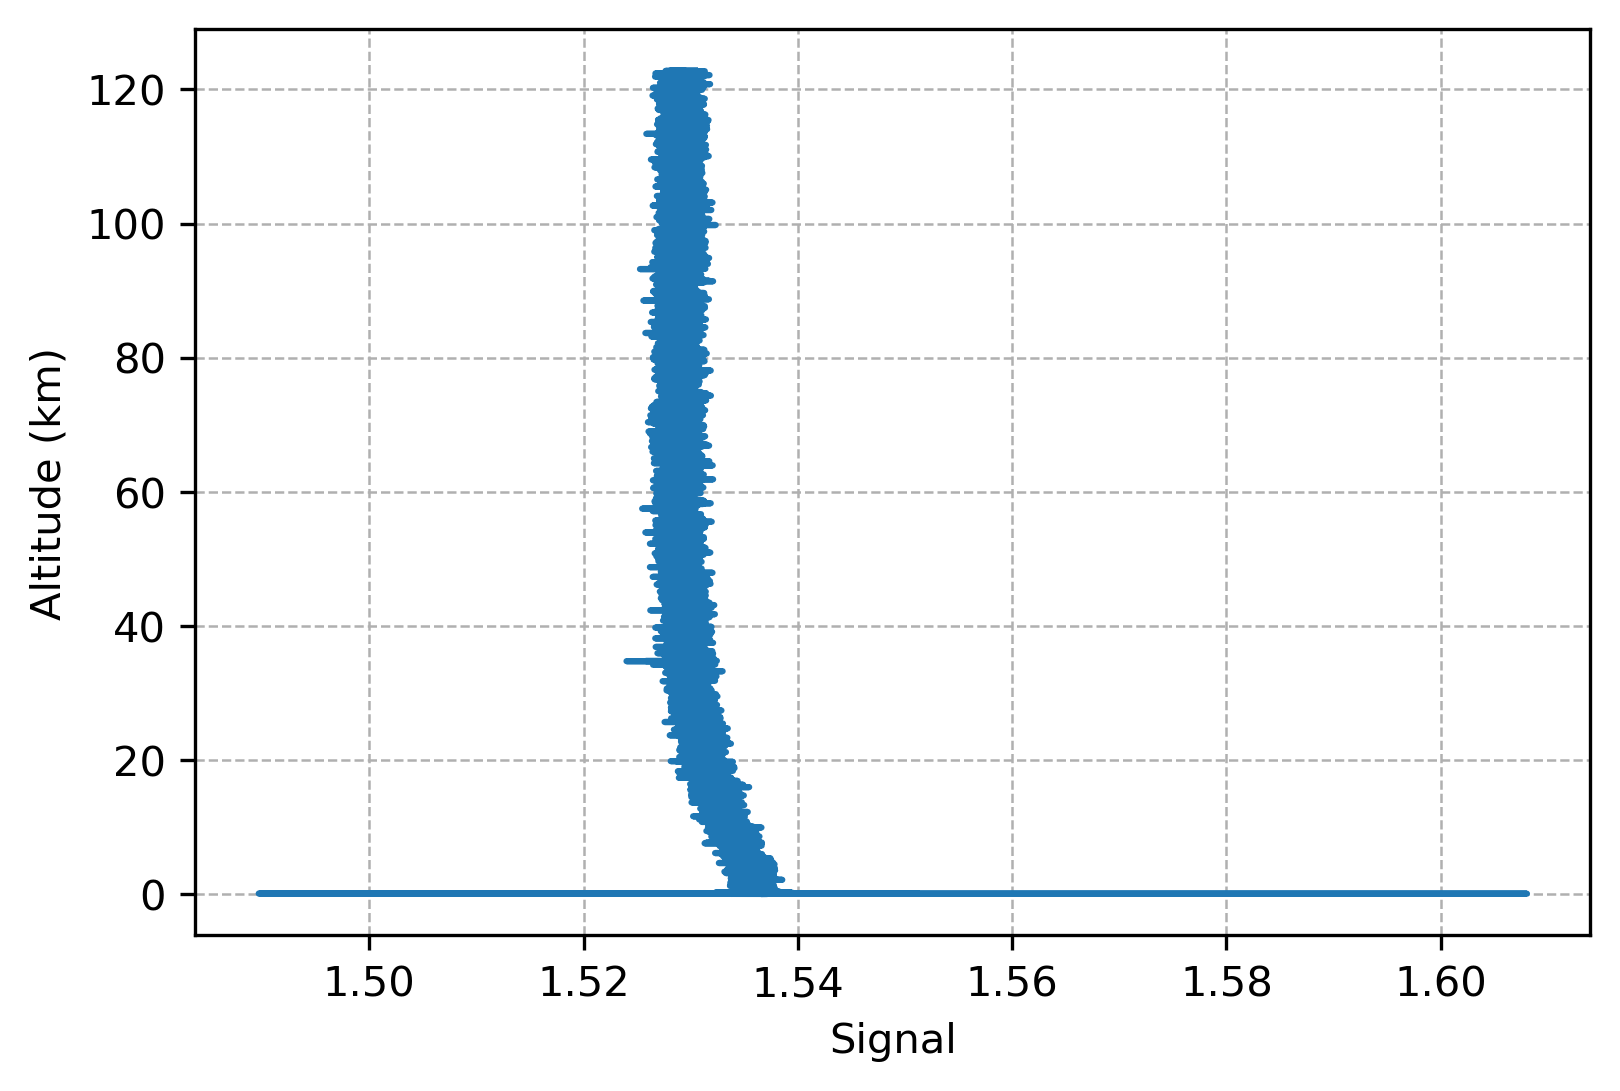

In [388]:
plt.figure(dpi=300)
plt.plot(dc, alt*1e-3)
plt.ylabel('Altitude (km)')
plt.xlabel('Signal')
plt.grid(linewidth=0.6, linestyle='--')
plt.savefig('DarkCurrent.png', dpi=300)

# Applying corrections to signal data

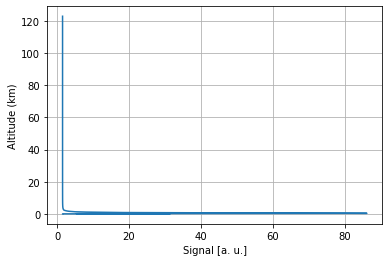

In [299]:
plt.plot(s355, alt*1e-3)
plt.grid(True)
plt.ylabel('Altitude (km)')
plt.xlabel('Signal [a. u.]')
#plt.ylim(0, 15)
plt.savefig('fig1', dpi=200)

## Picture for $log(P r^2)$

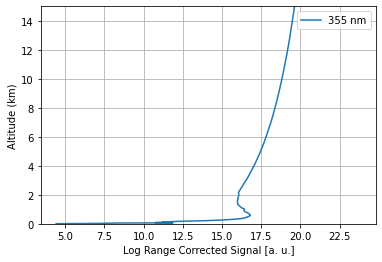

In [300]:
plt.plot(np.log(s355*alt*alt), alt*1e-3)
plt.grid(True)
plt.legend(['355 nm'])
plt.ylabel('Altitude (km)')
plt.xlabel('Log Range Corrected Signal [a. u.]')
plt.ylim(0, 15)
plt.savefig('fig3', dpi=200)

# Read temperature and pressure data

## Usando perfil artificial

z = alt
Pair = read[0]['P0']*np.exp(-(z-100)/8e3)    # H aproximadamente 8km
Tair = read[0]['T0'] - (9.8*1e-3)*z    # 6.5 lapse rate

Pair *= 100
Pair

plt.plot(Pair, alt*1e-3)
plt.grid(True)
plt.xlabel('Pressure [pa]')
plt.ylabel('Altitude [km]')
plt.ylim(0, 15)
plt.savefig('fig4', dpi=200)

Tair = read[0]['T0']+273.15 -0.006666666666668182*alt[:int(12000/7.5)]
Tair_p = Tair[-1]*np.ones(len(alt[int(12000/7.5):]))
Tair = np.concatenate((Tair, Tair_p), axis=0)

plt.plot(Tair, alt*1e-3)
plt.grid(True)
plt.xlabel('Temperature [K]')
plt.ylabel('Altitude [km]')
plt.ylim(0, 15)
plt.savefig('fig5', dpi=200)

PairTair = pd.read_fwf('PairTair.txt', header=None)

PairTair

## Usando dados de Wyoming

In [301]:
head['datei']

'19/08/2014'

If there is no data:

In [302]:
head = read[0]
date = datetime.strptime(head['datei'], '%d/%m/%Y').date()
#date = datetime.strptime('04/04/2014', '%d/%m/%Y').date()
print('Data:', date)
station = 'SBMN'

PairTair = WyomingUpperAir.request_data(date, station)

Data: 2014-08-19


In [303]:
PairTair

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,1001.0,84,27.8,21.8,100.0,3.0,-2.954423,0.520945,SBMN,82332,2014-08-19,-3.15,-59.98,84.0,32.02
1,1000.0,94,28.0,21.0,100.0,3.0,-2.954423,0.520945,SBMN,82332,2014-08-19,-3.15,-59.98,84.0,32.02
2,996.0,130,29.2,21.2,103.0,3.0,-2.923110,0.674853,SBMN,82332,2014-08-19,-3.15,-59.98,84.0,32.02
3,963.0,430,28.0,16.0,127.0,6.0,-4.791813,3.610890,SBMN,82332,2014-08-19,-3.15,-59.98,84.0,32.02
4,925.0,786,25.0,16.0,155.0,10.0,-4.226183,9.063078,SBMN,82332,2014-08-19,-3.15,-59.98,84.0,32.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,30.0,23810,-58.5,-89.5,95.0,49.0,-48.813540,4.270631,SBMN,82332,2014-08-19,-3.15,-59.98,84.0,32.02
94,27.3,24411,-56.5,-88.2,85.0,60.0,-59.771682,-5.229345,SBMN,82332,2014-08-19,-3.15,-59.98,84.0,32.02
95,27.0,24481,-56.3,-88.0,85.0,60.0,-59.771682,-5.229345,SBMN,82332,2014-08-19,-3.15,-59.98,84.0,32.02
96,23.0,25502,-52.9,-85.8,95.0,51.0,-50.805930,4.444943,SBMN,82332,2014-08-19,-3.15,-59.98,84.0,32.02


In [304]:
PairTair.units

{'pressure': 'hPa',
 'height': 'meter',
 'temperature': 'degC',
 'dewpoint': 'degC',
 'direction': 'degrees',
 'speed': 'knot',
 'u_wind': 'knot',
 'v_wind': 'knot',
 'station': None,
 'station_number': None,
 'time': None,
 'latitude': 'degrees',
 'longitude': 'degrees',
 'elevation': 'meter',
 'pw': 'millimeter'}

## Removendo todas as linhas com NaN

In [305]:
PairTair = PairTair.dropna()
PairTair

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,1001.0,84,27.8,21.8,100.0,3.0,-2.954423,0.520945,SBMN,82332,2014-08-19,-3.15,-59.98,84.0,32.02
1,1000.0,94,28.0,21.0,100.0,3.0,-2.954423,0.520945,SBMN,82332,2014-08-19,-3.15,-59.98,84.0,32.02
2,996.0,130,29.2,21.2,103.0,3.0,-2.923110,0.674853,SBMN,82332,2014-08-19,-3.15,-59.98,84.0,32.02
3,963.0,430,28.0,16.0,127.0,6.0,-4.791813,3.610890,SBMN,82332,2014-08-19,-3.15,-59.98,84.0,32.02
4,925.0,786,25.0,16.0,155.0,10.0,-4.226183,9.063078,SBMN,82332,2014-08-19,-3.15,-59.98,84.0,32.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,34.0,23028,-61.0,-91.3,80.0,50.0,-49.240388,-8.682409,SBMN,82332,2014-08-19,-3.15,-59.98,84.0,32.02
93,30.0,23810,-58.5,-89.5,95.0,49.0,-48.813540,4.270631,SBMN,82332,2014-08-19,-3.15,-59.98,84.0,32.02
94,27.3,24411,-56.5,-88.2,85.0,60.0,-59.771682,-5.229345,SBMN,82332,2014-08-19,-3.15,-59.98,84.0,32.02
95,27.0,24481,-56.3,-88.0,85.0,60.0,-59.771682,-5.229345,SBMN,82332,2014-08-19,-3.15,-59.98,84.0,32.02


In [306]:
alt_min = PairTair['height'].values[0]
alt_max = PairTair['height'].values[-21]
mask_range = np.where((alt >= alt_min) & (alt <= alt_max))[0]

In [307]:
alt[mask_range]

array([   90. ,    97.5,   105. , ..., 19290. , 19297.5, 19305. ])

In [308]:
Pair = 100*PairTair['pressure']           # Pa
Tair = 273.15 + PairTair['temperature']   # K

bg = np.mean(s355[-500:])

n_alt = alt[mask_range]
n_s355 = s355[mask_range]

x = PairTair['height']
y = Pair

f = interp1d(x, y, kind='cubic')
newPair = f(n_alt)


y = Tair
f = interp1d(x, y, kind='cubic')
newTair = f(n_alt)

In [309]:
bg

1.4779531385633682

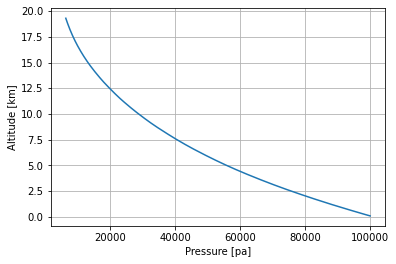

In [310]:
plt.plot(newPair, n_alt*1e-3)
plt.grid(True)
plt.xlabel('Pressure [pa]')
plt.ylabel('Altitude [km]')
#plt.ylim(0, 20)
plt.savefig('Pres_profile', dpi=200)

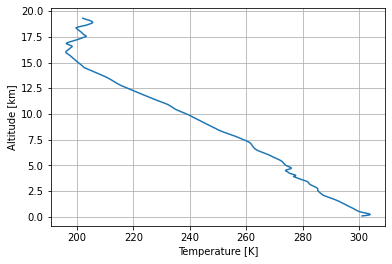

In [311]:
plt.plot(newTair, n_alt*1e-3)
plt.grid(True)
plt.xlabel('Temperature [K]')
plt.ylabel('Altitude [km]')
#plt.ylim(0, 20)
plt.savefig('Temp_profile', dpi=200)

# Molecular Scattering

In [312]:
%run alphabeta.ipynb

In [313]:
lambd = 355*1e-9
co2 = 400


alpha_mol, beta_mol, LR_mol = alphabeta(newPair, newTair, lambd, co2)

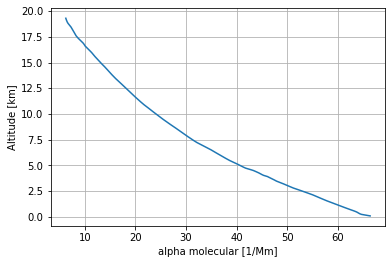

In [314]:
plt.plot(alpha_mol*1e6, n_alt*1e-3)
plt.grid(True)
plt.xlabel('alpha molecular [1/Mm]')
plt.ylabel('Altitude [km]')
plt.savefig('fig6', dpi=200)

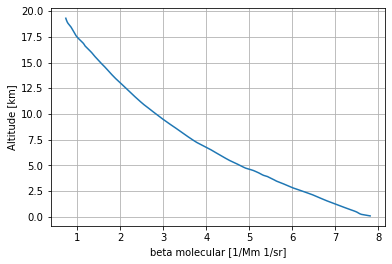

In [315]:
plt.plot(beta_mol*1e6, n_alt*1e-3)
plt.grid(True)
plt.xlabel('beta molecular [1/Mm 1/sr]')
plt.ylabel('Altitude [km]')
plt.savefig('fig7', dpi=200)

# Obtaining overlap

In [316]:
if date <= datetime.strptime('01/01/2013', "%d/%m/%Y").date():
    tipo = 'narrow'
    overlap_csv = 'overlap_narrow.csv'
else:
    tipo = 'wide'
    overlap_csv = 'overlap_wide.csv'

In [317]:
date

datetime.date(2014, 8, 19)

In [318]:
overlap = pd.read_csv(overlap_csv, header=None)
alt_o = alt[:overlap.shape[0]]
overlap['alt'] = alt_o
overlap.set_index('alt', inplace=True)
overlap

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
alt,,,,,,,,,,,,,,,,,,,,,
7.5,0.000082,0.000084,0.000084,0.000072,0.000073,0.000076,0.000079,0.000083,0.000074,0.000077,...,0.000085,0.000085,0.000089,0.000116,0.000098,0.000097,0.000098,0.000091,0.000098,0.000099
15.0,0.000114,0.000118,0.000117,0.000099,0.000101,0.000105,0.000109,0.000115,0.000103,0.000106,...,0.000117,0.000117,0.000122,0.000157,0.000132,0.000132,0.000133,0.000124,0.000133,0.000135
22.5,0.000149,0.000155,0.000154,0.000129,0.000132,0.000137,0.000143,0.000149,0.000133,0.000138,...,0.000152,0.000151,0.000158,0.000201,0.000170,0.000169,0.000170,0.000159,0.000171,0.000173
30.0,0.000192,0.000199,0.000198,0.000165,0.000168,0.000175,0.000183,0.000191,0.000170,0.000176,...,0.000193,0.000192,0.000200,0.000253,0.000214,0.000213,0.000215,0.000201,0.000216,0.000219
37.5,0.000240,0.000248,0.000247,0.000205,0.000209,0.000218,0.000226,0.000237,0.000212,0.000219,...,0.000238,0.000238,0.000247,0.000309,0.000263,0.000261,0.000263,0.000247,0.000265,0.000268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14970.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
14977.5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
14985.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


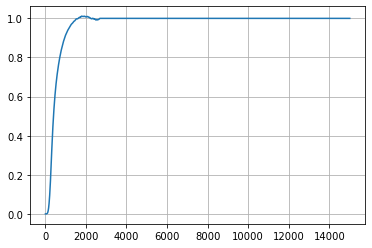

In [319]:
plt.plot(overlap[0])
plt.grid()

# Analisando a mudança dos overlaps

In [320]:
overlap_std = np.std(overlap, axis=1)
overlap_std

alt
7.5        0.000014
15.0       0.000018
22.5       0.000022
30.0       0.000026
37.5       0.000031
             ...   
14970.0    0.000000
14977.5    0.000000
14985.0    0.000000
14992.5    0.000000
15000.0    0.000000
Length: 2000, dtype: float64

In [321]:
alt_max = np.where(alt == 750)[0][0]

N = overlap.shape[1]
corr_matrix = np.zeros((N, N))

for i in range(N):
    for j in range(i, N):
        corr_matrix[i, j] = stats.pearsonr(overlap[i][:alt_max], overlap[j][:alt_max])[0]
        corr_matrix[j, i] = corr_matrix[i, j]

cont=0
for i in range(N):
    if corr_matrix[i, i] == 1:
        cont += 1

fig, ax = plt.subplots(figsize = (12,9))

psm = ax.imshow(corr_matrix)

cbar = fig.colorbar(psm, ax=ax, label = "Correlation value")
cbar.ax.tick_params(labelsize=15)

ax.set_xlabel("i", fontsize=20)

ax.set_ylabel("j", fontsize=20)

cbar.ax.tick_params(labelsize=15)

ax.tick_params(labelsize=15)

ax.figure.axes[-1].yaxis.label.set_size(20)

overlap_mean = np.mean(overlap, axis=1)

fig, axs = plt.subplots(2, 1, dpi=150, figsize=(6, 8))

xmax = 6.2

fig.subplots_adjust(hspace=0.3)
axs[0].plot(alt_o*1e-3, overlap_std, color='maroon')
axs[0].set_xlabel('Altitude (km)')
axs[0].set_xlim(-0.2, xmax)
axs[0].set_ylabel(r'$O(z)$ standard deviation')
axs[0].grid(linestyle='--', linewidth=0.8, alpha=0.4)

axs[1].plot(alt_o*1e-3, overlap_mean, color='maroon', label='Overlap mean')
axs[1].fill_between(alt_o*1e-3, overlap_mean-1*overlap_std, overlap_mean+1*overlap_std, facecolor='cornsilk', 
                 edgecolor='wheat', label='Overlap std', linestyle='-.',
                linewidth=0.8, alpha=1)
axs[1].grid(linestyle='--', linewidth=0.8, alpha=0.4)
axs[1].set_xlim(-0.2, xmax)
axs[1].set_xlabel('Altitude (km)')
axs[1].set_ylabel(r'$\langle O(z) \rangle$')
axs[1].legend()

plt.show()

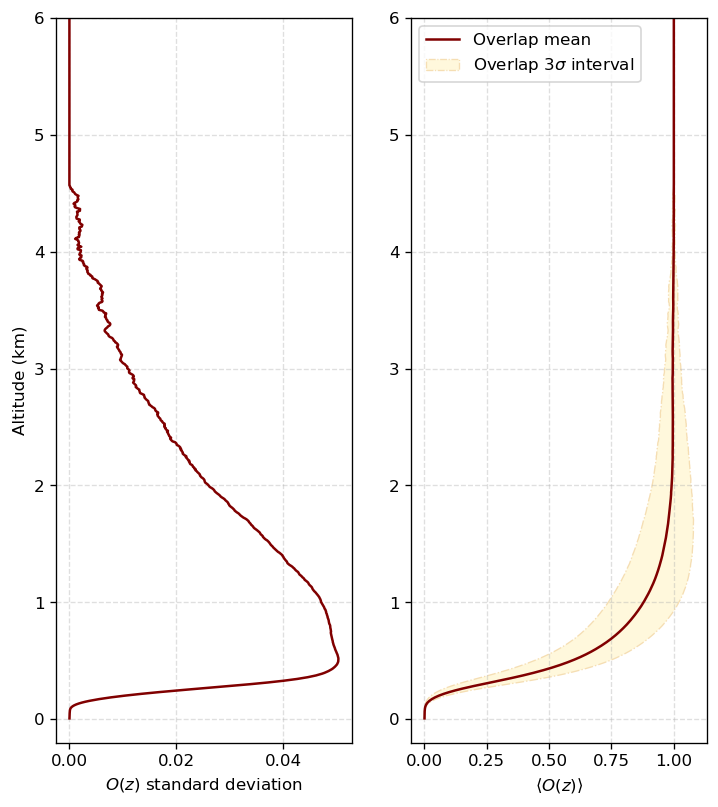

In [322]:
overlap_mean = np.mean(overlap, axis=1)

fig, axs = plt.subplots(1, 2, dpi=120, figsize=(7, 8))

xmax = 6.2
nsig = 3

fig.subplots_adjust(wspace=0.2)
axs[0].plot(overlap_std, alt_o*1e-3, color='maroon')
axs[0].set_ylabel('Altitude (km)')
#axs[0].set_xlim(-0.2, xmax)
axs[0].set_xlabel(r'$O(z)$ standard deviation')
axs[0].grid(linestyle='--', linewidth=0.8, alpha=0.4)
axs[0].set_ylim(-0.2, 6)
axs[1].plot(overlap_mean, alt_o*1e-3, color='maroon', label='Overlap mean')
axs[1].fill_betweenx(alt_o*1e-3, overlap_mean - nsig*overlap_std, overlap_mean + nsig*overlap_std, 
                     facecolor='cornsilk', edgecolor='wheat', label=r'Overlap ${} \sigma$ interval'.format(nsig), 
                     linestyle='-.', linewidth=0.8, alpha=1)
axs[1].grid(linestyle='--', linewidth=0.8, alpha=0.4)
#axs[1].set_xlim(-0.2, xmax)
#axs[1].set_ylabel('Altitude (km)')
axs[1].set_xlabel(r'$\langle O(z) \rangle$')
axs[1].legend(loc=0)
axs[1].set_ylim(-0.2, 6)
plt.savefig(f'Overlap_Analysis_{tipo}.png', dpi=300)
plt.show()


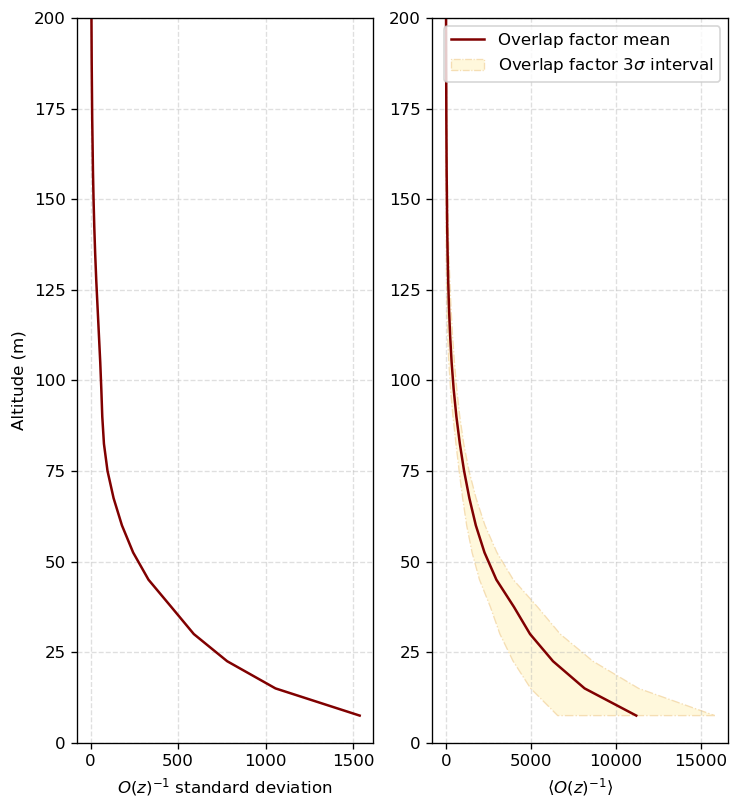

In [323]:
overlapf_mean = np.mean(1/overlap, axis=1)
overlapf_std = np.std(1/overlap, axis=1)

fig, axs = plt.subplots(1, 2, dpi=120, figsize=(7, 8))

xmax = 6.2
nsig = 3

fig.subplots_adjust(wspace=0.2)
axs[0].plot(overlapf_std, alt_o, color='maroon')
axs[0].set_ylabel('Altitude (m)')
#axs[0].set_xlim(-0.2, xmax)
axs[0].set_xlabel(r'$O(z)^{-1}$ standard deviation')
axs[0].grid(linestyle='--', linewidth=0.8, alpha=0.4)
axs[0].set_ylim(0, 200)
#axs[1].set_xscale('log')
axs[1].plot(overlapf_mean, alt_o, color='maroon', label='Overlap factor mean')
axs[1].fill_betweenx(alt_o, overlapf_mean - nsig*overlapf_std, overlapf_mean + nsig*overlapf_std, 
                     facecolor='cornsilk', edgecolor='wheat', label=r'Overlap factor ${} \sigma$ interval'.format(nsig), 
                     linestyle='-.', linewidth=0.8, alpha=1)
axs[1].grid(linestyle='--', linewidth=0.8, alpha=0.4)
#axs[1].set_xlim(-0.2, xmax)
#axs[1].set_ylabel('Altitude (km)')
axs[1].set_xlabel(r'$\langle O(z)^{-1} \rangle$')
axs[1].legend(loc=0)
axs[1].set_ylim(0, 200)
plt.savefig(f'OverlapFactor_{tipo}_Analysis.png', dpi=300)
plt.show()

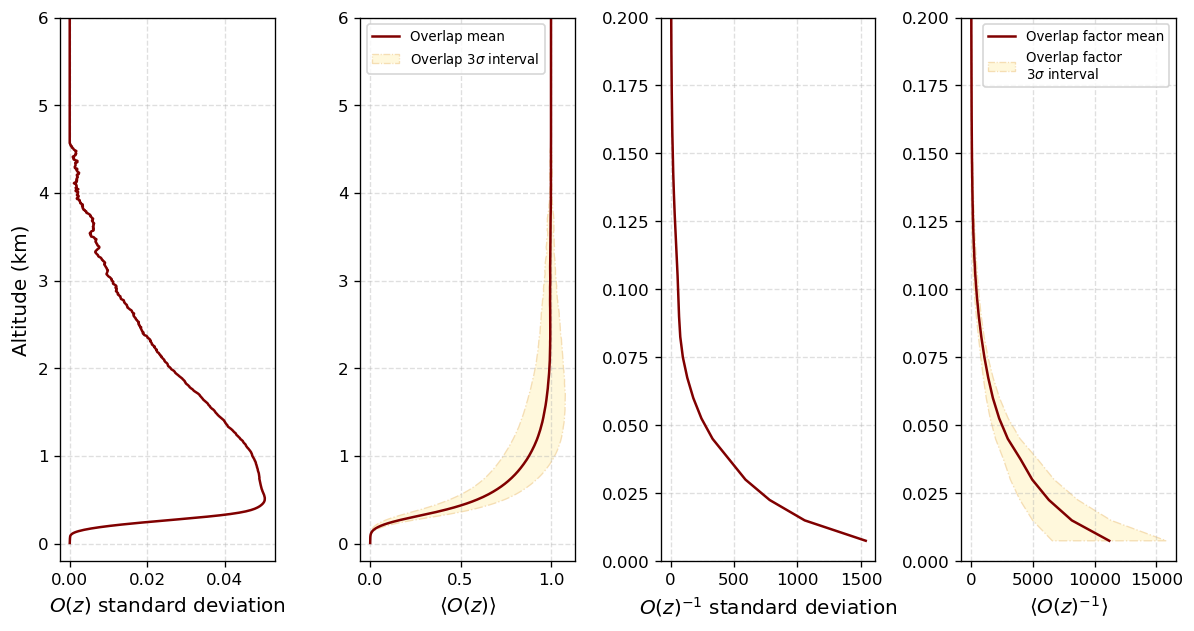

In [324]:
overlap_mean = np.mean(overlap, axis=1)

overlapf_mean = np.mean(1/overlap, axis=1)
overlapf_std = np.std(1/overlap, axis=1)

fig, axs = plt.subplots(1, 4, dpi=120, figsize=(12, 6))

xmax = 6.2
nsig = 3

fig.subplots_adjust(wspace=0.4)
axs[2].plot(overlapf_std, alt_o*1e-3, color='maroon')
axs[0].set_ylabel('Altitude (km)', fontsize=12)
#axs[0].set_xlim(-0.2, xmax)
axs[2].set_xlabel(r'$O(z)^{-1}$ standard deviation', fontsize=12)
axs[2].grid(linestyle='--', linewidth=0.8, alpha=0.4)
axs[2].set_ylim(0, 0.2)
#axs[1].set_xscale('log')
axs[3].plot(overlapf_mean, alt_o*1e-3, color='maroon', label='Overlap factor mean')
axs[3].fill_betweenx(alt_o*1e-3, overlapf_mean - nsig*overlapf_std, overlapf_mean + nsig*overlapf_std, 
                     facecolor='cornsilk', edgecolor='wheat', label='Overlap factor\n' + r'${} \sigma$ interval'.format(nsig), 
                     linestyle='-.', linewidth=0.8, alpha=1)
axs[3].grid(linestyle='--', linewidth=0.8, alpha=0.4)
#axs[1].set_xlim(-0.2, xmax)
#axs[1].set_ylabel('Altitude (km)')
axs[3].set_xlabel(r'$\langle O(z)^{-1} \rangle$', fontsize=12)
axs[3].legend(loc=0, fontsize=8)
axs[3].set_ylim(0, 0.2)

axs[0].plot(overlap_std, alt_o*1e-3, color='maroon')
#axs[2].set_ylabel('Altitude (km)')
#axs[0].set_xlim(-0.2, xmax)
axs[0].set_xlabel(r'$O(z)$ standard deviation', fontsize=12)
axs[0].grid(linestyle='--', linewidth=0.8, alpha=0.4)
axs[0].set_ylim(-0.2, 6)
axs[1].plot(overlap_mean, alt_o*1e-3, color='maroon', label='Overlap mean')
axs[1].fill_betweenx(alt_o*1e-3, overlap_mean - nsig*overlap_std, overlap_mean + nsig*overlap_std, 
                     facecolor='cornsilk', edgecolor='wheat', label=r'Overlap ${} \sigma$ interval'.format(nsig), 
                     linestyle='-.', linewidth=0.8, alpha=1)
axs[1].grid(linestyle='--', linewidth=0.8, alpha=0.4)
#axs[1].set_xlim(-0.2, xmax)
#axs[1].set_ylabel('Altitude (km)')
axs[1].set_xlabel(r'$\langle O(z) \rangle$', fontsize=12)
axs[1].legend(loc=0, fontsize=8)
axs[1].set_ylim(-0.2, 6)
plt.savefig(f'Overlap_Analysis_{tipo}_JOIN.png', dpi=300)
plt.show()

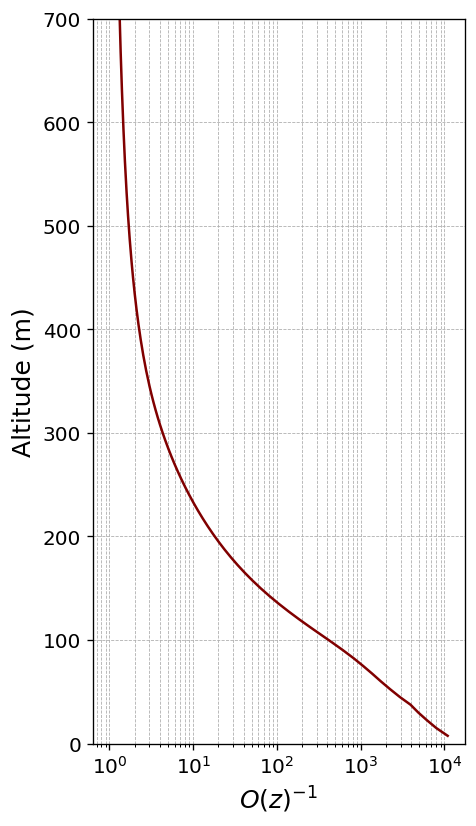

In [325]:
plt.figure(figsize=(4, 8), dpi=120)
plt.plot((1/overlap_mean), alt_o, color='maroon')
plt.ylabel('Altitude (m)', fontsize=15)
plt.xlabel(r'$O(z)^{-1}$', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xscale('log')
plt.grid(linewidth=0.5, alpha=1, linestyle='--', which='both')
plt.ylim(0, 700)
plt.show()

# built the simulated molecular signal

In [326]:
mean_overlap = overlap_mean.values[mask_range[0]:]
altmax = mean_overlap.shape[0]

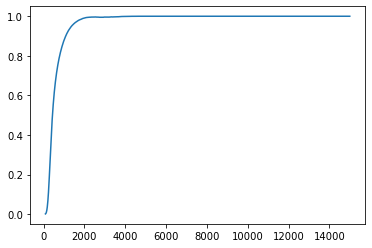

In [327]:
plt.plot(overlap_mean.index[mask_range[0]:], mean_overlap)

In [328]:
s355_bg = n_s355 - bg          # Subtraindo o background
s355_bg2 = np.concatenate((s355_bg[:altmax]/mean_overlap, s355_bg[altmax:]), axis=0)   #Dividindo pelo overlap
#n_alt = alt[11:3145]       #COMENTEI ISSO AQUI
n_s355 = s355_bg2

In [329]:
alt[mask_range[0]:]

array([9.000000e+01, 9.750000e+01, 1.050000e+02, ..., 1.228350e+05,
       1.228425e+05, 1.228500e+05])

In [338]:
n_alt

array([   90. ,    97.5,   105. , ..., 19290. , 19297.5, 19305. ])

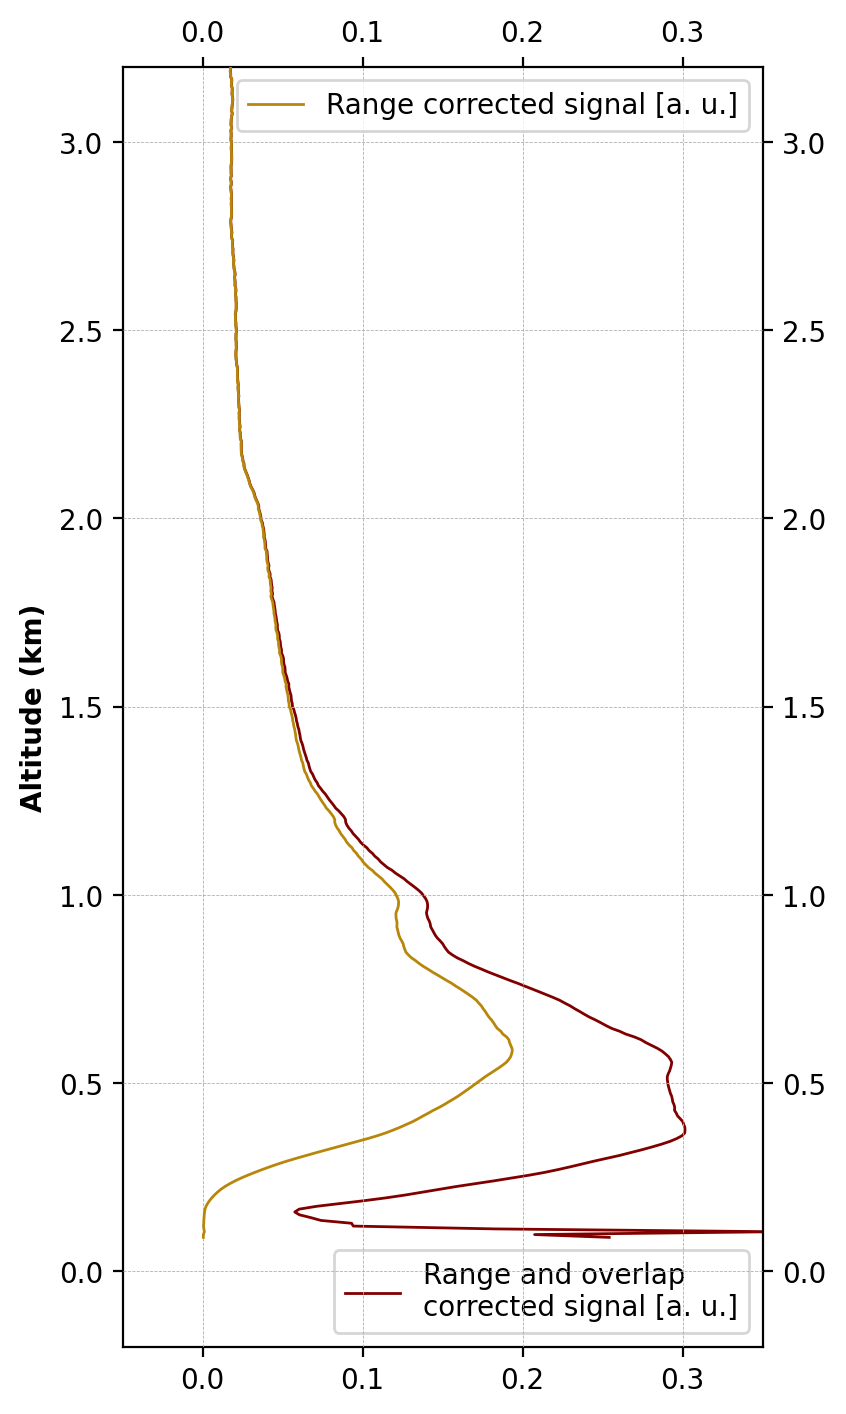

In [330]:
from matplotlib.axes import Axes
from matplotlib import rcParams
#rcParams.update({'figure.autolayout': True})

rect = 0.1, 0.1, 0.8, 0.8

fig = plt.figure(figsize=(4, 8), dpi=200)
ax1 = fig.add_axes(rect)

ax1.plot(n_s355*n_alt**2 * 1e-8, n_alt*1e-3, c='maroon', 
         label='Range and overlap \ncorrected signal [a. u.]', 
         linewidth=1)
#ax1.set_xlabel('Range and overlap corrected signal [a. u.]', color='maroon', fontweight='bold')
ax1.set_ylabel('Altitude (km)', fontweight='bold')
ax1.set_ylim(-0.2, 3.2)
ax1.set_xlim(-0.05, 0.35)

ax2 = fig.add_axes(rect, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')

ax2.plot((s355[mask_range[0]:]-bg)*alt[mask_range[0]:]**2 * 1e-8, alt[mask_range[0]:]*1e-3, 
         'darkgoldenrod', label='Range corrected signal [a. u.]', linewidth=1)
#ax2.set_xlabel('Range corrected signal [a. u.]', color='darkgoldenrod', fontweight='bold')
#ax2.set_ylabel(r'Altitude (km)', fontweight='bold')
ax2.set_ylim(-0.2, 3.2)
ax2.set_xlim(-0.05, 0.35)

ax1.legend(loc=4)
ax2.legend(loc=1)
plt.grid(linestyle='--', linewidth=0.3)

#plt.savefig('Comparison_Overlap.png', bbox_inches="tight")
plt.show()

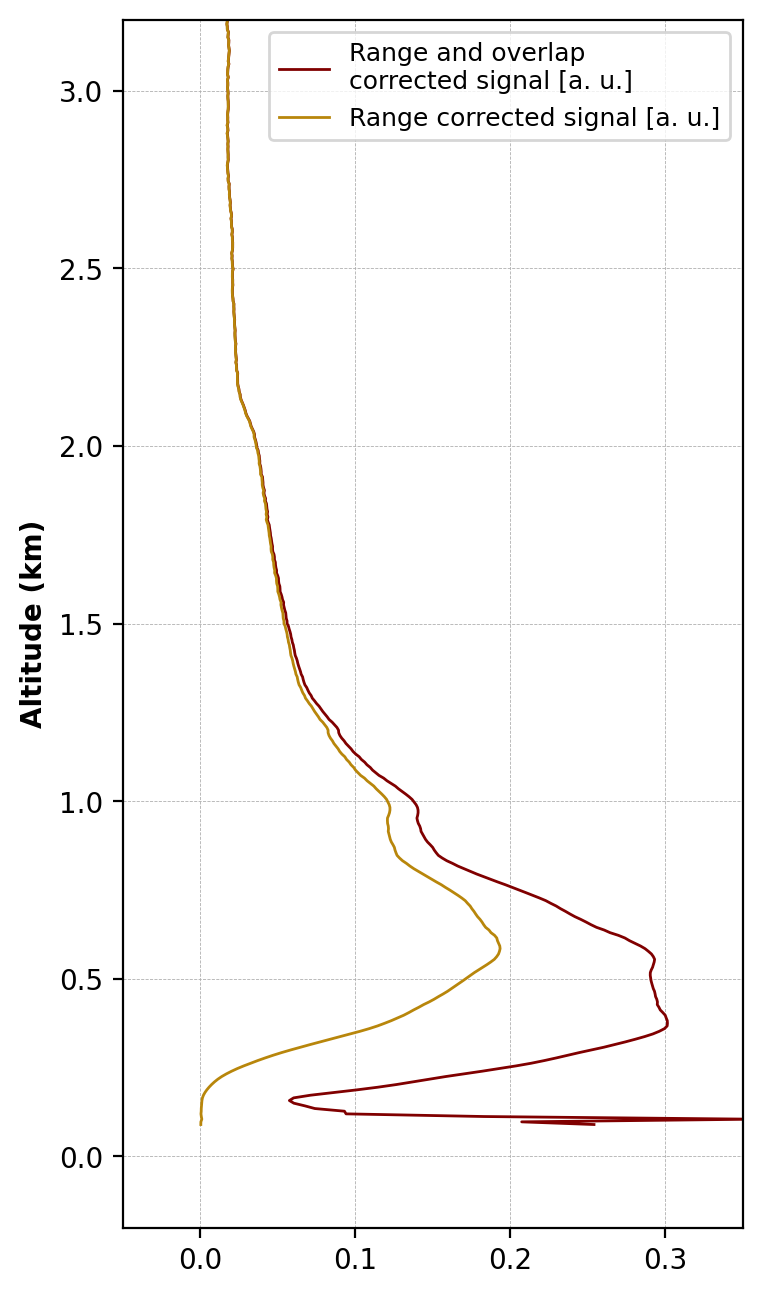

In [337]:
plt.figure(figsize=(4, 8), dpi=200)

plt.plot(n_s355*n_alt**2 * 1e-8, n_alt*1e-3, c='maroon', 
         label='Range and overlap \ncorrected signal [a. u.]', 
         linewidth=1)
plt.plot((s355[mask_range[0]:]-bg)*alt[mask_range[0]:]**2 * 1e-8, alt[mask_range[0]:]*1e-3, 
         'darkgoldenrod', label='Range corrected signal [a. u.]', linewidth=1)

#ax1.set_xlabel('Range and overlap corrected signal [a. u.]', color='maroon', fontweight='bold')
plt.ylabel('Altitude (km)', fontweight='bold')
plt.ylim(-0.2, 3.2)
plt.xlim(-0.05, 0.35)
plt.legend(loc=1, fontsize=9)
plt.grid(linestyle='--', linewidth=0.3)

plt.savefig('Comparison_Overlap.png', bbox_inches="tight")
plt.show()

In [339]:
len(n_s355)

2563

In [340]:
meteo_alt = n_alt
len(meteo_alt)

2563

In [341]:
model = (beta_mol * np.exp(-2*integrate.cumtrapz(alpha_mol, meteo_alt, initial=0))) / meteo_alt**2

(1e-10, 100000000000000.0)

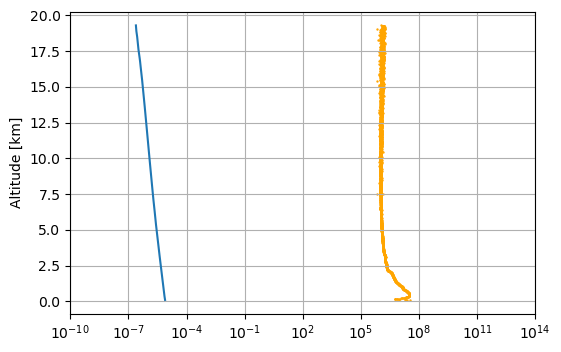

In [342]:
plt.figure(dpi=100)
plt.semilogx(model*meteo_alt*meteo_alt, meteo_alt*1e-3)
plt.scatter((n_s355)*n_alt*n_alt, n_alt*1e-3, s=0.5, c='orange')
plt.grid(True)
plt.ylabel('Altitude [km]')
plt.xlim(1e-10, 1e14)

## Determinando a região do ajuste

In [343]:
alt_min = 6      # km
alt_max = 10     # km

index_min = int(alt_min*1e3/7.5)
index_max = int(alt_max*1e3/7.5)

Text(0, 0.5, 'Measured signal')

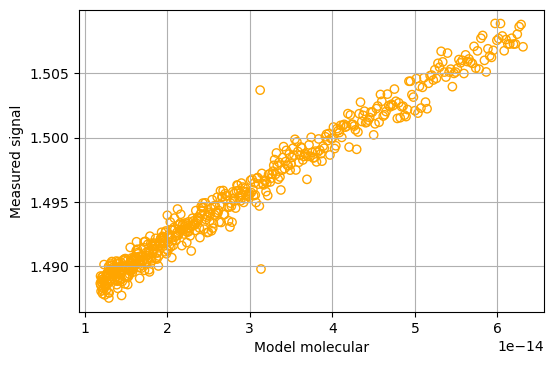

In [344]:
plt.figure(dpi=100)
plt.scatter(model[index_min:index_max], s355[index_min:index_max], facecolors = 'none', edgecolors = 'orange')
plt.grid(True)
plt.xlabel('Model molecular')
plt.ylabel('Measured signal')

In [345]:
f = lambda x, a, b: a*x + b

fit = optimize.curve_fit(f, model[index_min:index_max], n_s355[index_min:index_max], p0=(1e13, 0))

a = fit[0][0]
b = fit[0][1]

fit

(array([3.76505919e+11, 6.17921037e-03]),
 array([[ 7.09299795e+18, -2.07726561e+05],
        [-2.07726561e+05,  7.50511114e-09]]))

In [346]:
b/np.sqrt(fit[1][1, 1])

71.32707534839929

Text(0, 0.5, 'Measured signal')

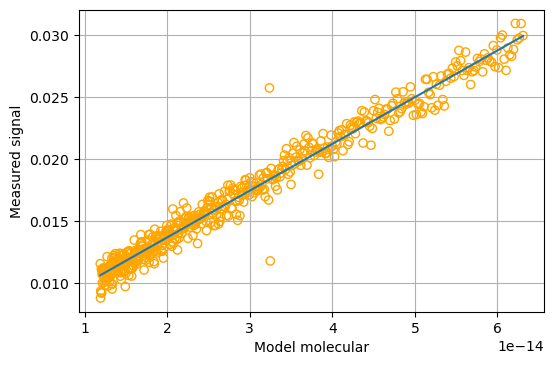

In [347]:
plt.figure(dpi=100)
plt.scatter(model[index_min:index_max], n_s355[index_min:index_max], facecolors = 'none', edgecolors = 'orange')
plt.plot(model[index_min:index_max], f(model[index_min:index_max], a, b))
plt.grid(True)
plt.xlabel('Model molecular')
plt.ylabel('Measured signal')

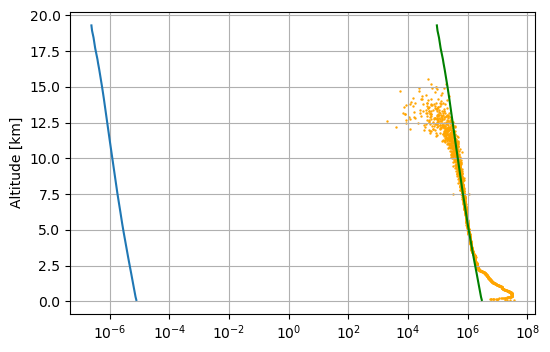

In [348]:
plt.figure(dpi=100)
plt.semilogx(model*meteo_alt*meteo_alt, meteo_alt*1e-3)
plt.scatter((n_s355 - b)*n_alt*n_alt, n_alt*1e-3, c='orange', s=0.5)
plt.semilogx((model*a)*meteo_alt*meteo_alt, meteo_alt*1e-3, c='green')
plt.grid(True)
plt.ylabel('Altitude [km]')
#plt.xlim(1e-10, 1e15)
plt.savefig('fig8', dpi=200)

In [365]:
%run fernald_new1.ipynb

# Devemos sempre entrar com vetores coluna no algoritmo de inversao

zref = np.array([6*1e3, 14*1e3])
LR = 28.
LR = 65. # Para queimada esse valor de LR

z          = n_alt   [:, None]
pr         = n_s355  [:, None]
ref        = zref    [:, None]
lambd      = 355*1e-9
LidarRatio = LR
Pair       = newPair [:, None]
Tair       = newTair [:, None]


beta_par, alpha_par, LR_par, model_mol, ab_fit = fernald_new1(z, pr, ref, lambd, LidarRatio, Pair, Tair)

## Devemos restringir o plot a partir de 750m porque antes o overlap varia mto

In [366]:
print(date)

2014-08-19


In [367]:
n_alt[88]

750.0

In [368]:
lim = 88
beta_par['aer']  = beta_par ['aer'][lim:]
beta_par['mol']  = beta_par ['mol'][lim:]
beta_par['tot']  = beta_par ['tot'][lim:]
alpha_par['aer'] = alpha_par['aer'][lim:]
alpha_par['mol'] = alpha_par['mol'][lim:]
alpha_par['tot'] = alpha_par['tot'][lim:]
n_alt2           = n_alt[lim:]

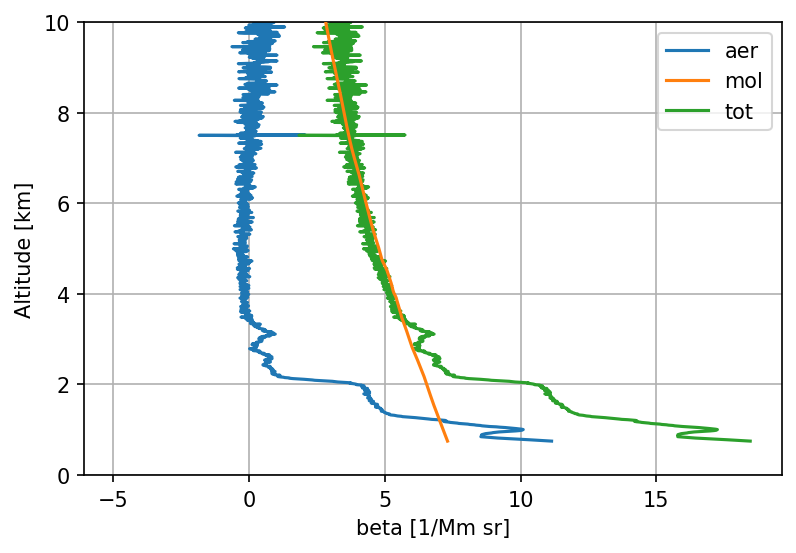

In [369]:
plt.figure(dpi=150)
plt.plot(beta_par['aer']*1e6, n_alt2*1e-3)
plt.plot(beta_par['mol']*1e6, n_alt2*1e-3, zorder=3)
plt.plot(beta_par['tot']*1e6, n_alt2*1e-3)
plt.grid(True)
plt.legend(['aer', 'mol', 'tot'])
#plt.xlim(-8, 23)
plt.ylim(0, 10)
plt.xlabel('beta [1/Mm sr]')
plt.ylabel('Altitude [km]')
plt.savefig(f'backscatter_{date}2.png', dpi=300)

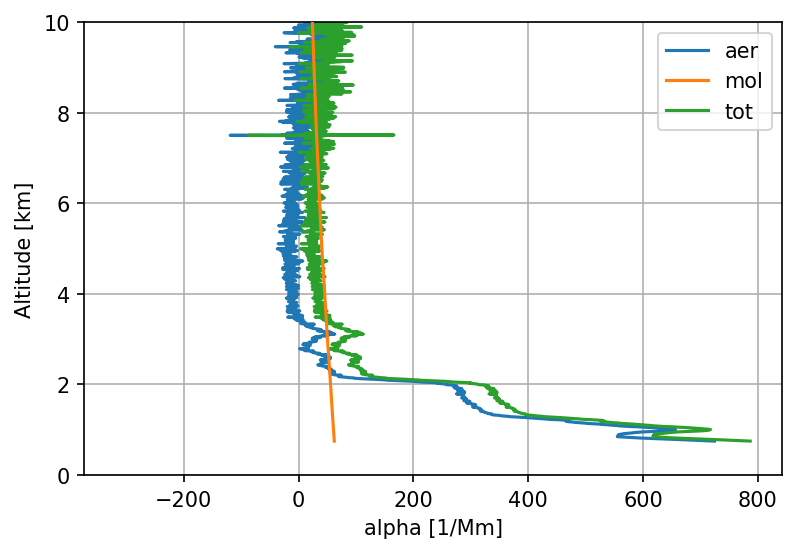

In [370]:
plt.figure(dpi=150)
plt.plot(alpha_par['aer']*1e6, n_alt2*1e-3)
plt.plot(alpha_par['mol']*1e6, n_alt2*1e-3, zorder=3)
plt.plot(alpha_par['tot']*1e6, n_alt2*1e-3)
plt.grid(True)
plt.legend(['aer', 'mol', 'tot'])
#plt.xlim(-550, 1150)
plt.ylim(0, 10)
plt.xlabel('alpha [1/Mm]')
plt.ylabel('Altitude [km]')
plt.savefig(f'alpha_{date}2.png', dpi=300)

## Estimating AOD

In [371]:
mask = np.where(n_alt2 <= 6000)[0]

In [372]:
AOD = (alpha_par['aer'][0]*n_alt2[0])[0]

In [373]:
AOD += np.trapz(np.reshape(alpha_par['aer'][mask], len(mask)), n_alt2[mask], dx=7.5)
AOD

1.0973657443060671